In [10]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import sys
import os

parent_dir = os.path.abspath(os.path.join(os.getcwd(), '..'))
sys.path.append(parent_dir)

from gaussian_process import *

%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [11]:
df = pd.read_csv("../Metro_Interstate_Traffic_Volume.csv")
df['date_time'] = pd.to_datetime(df['date_time'])
df['hour'] = df['date_time'].dt.hour
df['day_of_week'] = df['date_time'].dt.dayofweek
df['month'] = df['date_time'].dt.month
df['year'] = df['date_time'].dt.year
df['is_holiday'] = (~ df['holiday'].isnull()).astype(int)
df['time_step'] = (df['date_time'] - pd.Timestamp("2012-10-02 09:00:00")) // pd.Timedelta(hours=1) # hours since 2012-10-20 9am

# Training data
df_train = df[df['date_time'].dt.year.isin([2016, 2017])] # 2016, 2016 as training data
df_test = df[df['date_time'].dt.year.isin([2018])] # 2018 for validation

# only include time data
X_train = df_train[['time_step']]
X_test = df_test[['time_step']]

y_train = df_train['traffic_volume']
y_test = df_test['traffic_volume']

In [12]:
print(len(X_train))
print(len(X_test))

19911
7949


In [13]:
def adj_gp_posterior(X_train, y_train, X_test, kernel, noise=1e-8, **kwargs):
    """Compute posterior mean and covariance of GP. Returns mean and covariance for train and test as well as alpha and v"""
    n = len(X_train)
    n_tst = len(X_test)

    print("Computing Gram Matrix")
    K = kernel(X_train, X_train, **kwargs)
    K_noisy = K + noise * np.eye(n) # kernel fcn between train data (plus noise)
    b = kernel(X_train, X_test, **kwargs) # kernel fcn between train and test data
    c = kernel(X_test, X_test, **kwargs)# kernel fcn between test data

    print('Computing Cholesky Decomposition')
    L = np.linalg.cholesky(K_noisy)

    print('Computing alpha')
    alpha = np.linalg.solve(L.T, np.linalg.solve(L, y_train))

    print('Computing Mean and Covariance')
    mu_tst = b.T.dot(alpha) # mean for test points
    mu_tr = K.dot(alpha)
    v = np.linalg.solve(L, b)
    cov_tst = c - v.T @ v


    return mu_tst, cov_tst, mu_tr, alpha, v

In [33]:
l = 0.1
p = 24*7
s = 1.0

print(f'Length Scale = {l}, Period = {p}, Variance = {s}')

# fit GP model
mean_test, cov_test, mean_train, _, _ = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

# get interval for test
stdv = np.sqrt(np.diag(cov_test))
upper = mean_test + 2 * stdv
lower = mean_test - 2 * stdv

Length Scale = 0.1, Period = 168, Variance = 1.0
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance


In [34]:
train_rmse = rmse(y_train, mean_train)
test_rmse = rmse(y_test, mean_test)

train_mae = mae(y_train, mean_train)
test_mae = mae(y_test, mean_test)

print(f"Train RMSE : {train_rmse}")
print(f"Test RMSE : {test_rmse}")

print(f"Train MAE : {train_mae}")
print(f"Test MAE : {test_mae}")

Train RMSE : 504.2502112838889
Test RMSE : 524.0647542148128
Train MAE : 294.0219516880598
Test MAE : 296.099744810996


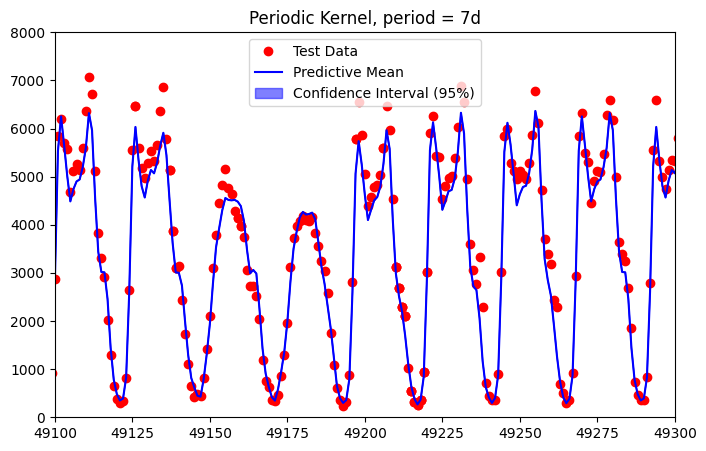

In [38]:
# Plot
plt.figure(figsize=(8, 5))
plt.plot(X_test['time_step'], y_test, 'ro', label='Test Data')

plt.plot(X_test['time_step'], mean_test, 'b-', label='Predictive Mean')
plt.fill_between(X_test['time_step'], lower, upper, color='blue', alpha=0.5, label='Confidence Interval (95%)')
plt.title(f"Periodic Kernel, period = 7d")
plt.xlim(49100, 49300)
plt.ylim(0, 8000)
plt.legend()
plt.show()

## Test Experiments

In [14]:
# periodic kernel experiments (1 week)
lst_l = [0.01, 0.1, 1]
p = 24*7
s = 1

results = []


for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_1w_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_1w_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_1w_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_1w_l{l}_s{s}', mean_train)

    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })
    print()

results = pd.DataFrame(results)
print(results)

Length Scale = 0.01, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 504.019878212502
Test RMSE : 524.0630710810844

Length Scale = 0.1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 504.2502112838889
Test RMSE : 524.0647542148128

Length Scale = 1, Period = 168, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1010.9311065378025
Test RMSE : 1017.5635771770341

   length_scale  period  variance   train_rmse    test_rmse  train_mae  \
0          0.01     168         1   504.019878   524.063071  17.135188   
1          0.10     168         1   504.250211   524.064754  17.147068   
2          1.00     168         1  1010.931107  1017.563577  27.551699   

    test_mae  
0  17.196407  
1  17.207549  
2  27.748805  


In [15]:
# periodic kernel experiments (30 days)
lst_l = [0.01, 0.1, 1]
p = 24*30
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_30d_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_30d_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_30d_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_30d_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })
    print()

results = pd.DataFrame(results)
display(results)

Length Scale = 0.01, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 908.343070329353
Test RMSE : 964.9699512434387

Length Scale = 0.1, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1045.127533052838
Test RMSE : 1079.4898307087992

Length Scale = 1, Period = 720, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1968.7541202106447
Test RMSE : 1973.1704943588281



,length_scale,period,variance,train_rmse,test_rmse,train_mae,test_mae
0,0.01,720,1,908.343070,964.969951,24.729560,25.533600
1,0.10,720,1,1045.127533,1079.489831,27.696265,28.144226
2,1.00,720,1,1968.754120,1973.170494,41.599969,41.565729


In [16]:
# periodic kernel experiments (365 days)
lst_l = [0.01, 0.1, 1]
p = 24*365
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, periodic_kernel, length_scale = l, period = p, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_periodic_365d_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_365d_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_365d_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_365d_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
display(results)

Length Scale = 0.01, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 971.3840574612678
Test RMSE : 1308.6678906821942

Length Scale = 0.1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1926.850566887171
Test RMSE : 1985.6618697804624

Length Scale = 1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1962.645354920789
Test RMSE : 1977.3158143036483



,length_scale,period,variance,train_rmse,test_rmse,train_mae,test_mae
0,0.01,8760,1,971.384057,1308.667891,727.010672,998.101065
1,0.10,8760,1,1926.850567,1985.661870,1693.576771,1727.298521
2,1.00,8760,1,1962.645355,1977.315814,1725.094099,1728.478889


In [17]:
# rbf kernel
lst_l = [0.01, 0.1, 1]
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, rbf_kernel, length_scale = l, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_rbf_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_rbf_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_rbf_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_rbf_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
print(results)

Length Scale = 0.01, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 3.357401060387935e-05
Test RMSE : 3810.6344561615124

Length Scale = 0.1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 3.357401060388029e-05
Test RMSE : 3810.6344561615124

Length Scale = 1, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1.9352591336483476e-05
Test RMSE : 3810.599525161915

   length_scale  period  variance  train_rmse    test_rmse  train_mae  \
0          0.01    8760         1    0.000034  3810.634456   0.000027   
1          0.10    8760         1    0.000034  3810.634456   0.000027   
2          1.00    8760         1    0.000019  3810.599525   0.000014   

      test_mae  
0  3260.112341  
1  3260.112341  
2  3259.9

In [23]:
# rbf kernel
lst_l = [10, 100, 1000]
s = 1

results = []

for l in lst_l:
    print(f'Length Scale = {l}, Period = {p}, Variance = {s}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, rbf_kernel, length_scale = l, variance = s)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_rbf_l{l}_s{s}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_rbf_l{l}_s{s}', mean_test)
    np.save(f'../results/cov_test_rbf_l{l}_s{s}', cov_test)
    np.save(f'../results/mean_train_rbf_l{l}_s{s}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
print(results)

Length Scale = 10, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 622.0723668827254
Test RMSE : 6334.892008419101

Length Scale = 100, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1908.4804510983813
Test RMSE : 555618.8240636206

Length Scale = 1000, Period = 8760, Variance = 1
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1957.8448361571905
Test RMSE : 321944.57572411466

   length_scale  period  variance   train_rmse      test_rmse    train_mae  \
0            10    8760         1   622.072367    6334.892008   469.637507   
1           100    8760         1  1908.480451  555618.824064  1676.925134   
2          1000    8760         1  1957.844836  321944.575724  1720.787935   

        test_mae  
0    3532.093451  
1  111904.552

In [18]:
# sum of periodic
def sum_periodic(x1, x2, l1, p1, w1, l2, p2, w2): # weighted sum of 2 periodic kernels
    return w1*periodic_kernel(x1, x2, l1, p1) + w2*periodic_kernel(x1, x2, l2, p2)

In [ ]:
# sum of periodic kernels
l1 = 0.1
p1 = 7*24
l2 = 0.2
p2 = 24*365
w2 = 1
results = []

for w1 in [0.1, 1, 5, 10]:
    print(f'Length Scale 1 = {l1}, Period 1 = {p1}, Length Scale 2 = {l2}, Period 2 = {p2}')
    print(f'Weights {w1, w2}')
    mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, sum_periodic, l1 = l1, p1 = p1, l2 = l2, p2 = p2, w1 = w1, w2 = w2)

    # get interval for test
    stdv = np.sqrt(np.diag(cov_test))
    upper = mean_test + 2 * stdv
    lower = mean_test - 2 * stdv

    train_rmse = rmse(y_train, mean_train)
    test_rmse = rmse(y_test, mean_test)

    train_mae = mae(y_train, mean_train)
    test_mae = mae(y_test, mean_test)

    print(f"Train RMSE : {train_rmse}")
    print(f"Test RMSE : {test_rmse}")
    
    #print(f"Train MAE : {train_mae}")
    #print(f"Test MAE : {test_mae}")

    np.save(f'../results/alpha_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', alpha) # save alpha matrix
    np.save(f'../results/mean_test_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', mean_test)
    np.save(f'../results/cov_test_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', cov_test)
    np.save(f'../results/mean_train_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', mean_train)
    
    results.append({
        'length_scale': l,
        'period': p,
        'variance': s,
        'train_rmse': train_rmse,
        'test_rmse': test_rmse,
        'train_mae': train_mae,
        'test_mae': test_mae
    })

    print()

results = pd.DataFrame(results)
print(results)

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 0.2, Period 2 = 8760
Weights (0.1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 456.26726143255064
Test RMSE : 530.5726558763229

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 0.2, Period 2 = 8760
Weights (1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 456.00826290924135
Test RMSE : 530.4459504569616

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 0.2, Period 2 = 8760
Weights (5, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 455.9823821417879
Test RMSE : 530.4311351125333

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 0.2, Period 2 = 8760
Weights (10, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 455.9885494035131
Test RMSE 

In [26]:
# sum of periodic
def local_periodic(x1, x2, l1, l2, p2): # weighted sum of 2 periodic kernels
    return rbf_kernel(x1, x2, length_scale = l1)*periodic_kernel(x1, x2, length_scale = l2, period = p2)

In [27]:
# local periodic (rbf * periodic)
l1 = 0.1
l2 = 0.2
p2 = 24*7
w2 = 1
results = []

for l1 in [1, 10, 100]:
    for l2 in [0.1, 1, 10]:
        print(f'Length Scale 1 = {l1}, Length Scale 2 = {l2}, Period = {p2}')
        mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, local_periodic, l1 = l1, l2 = l2, p2 = p2)

        # get interval for test
        stdv = np.sqrt(np.diag(cov_test))
        upper = mean_test + 2 * stdv
        lower = mean_test - 2 * stdv

        train_rmse = rmse(y_train, mean_train)
        test_rmse = rmse(y_test, mean_test)

        train_mae = mae(y_train, mean_train)
        test_mae = mae(y_test, mean_test)

        print(f"Train RMSE : {train_rmse}")
        print(f"Test RMSE : {test_rmse}")
        
        #print(f"Train MAE : {train_mae}")
        #print(f"Test MAE : {test_mae}")

        np.save(f'../results/alpha_sum_local_per_7d_1yr_l1{l1}_l1{l2}_p{p2}', alpha) # save alpha matrix
        np.save(f'../results/mean_test_sum_local_per_7d_1yr_l1{l1}_l1{l2}_p{p2}', mean_test)
        np.save(f'../results/cov_test_sum_local_per_7d_1yr_l1{l1}_l1{l2}_p{p2}', cov_test)
        np.save(f'../results/mean_train_sum_local_per_7d_1yr_l1{l1}_l1{l2}_p{p2}', mean_train)
        
        results.append({
            'length_scale': l,
            'period': p,
            'variance': s,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae
        })

        print()

results = pd.DataFrame(results)
print(results)

Length Scale 1 = 1, Length Scale 2 = 0.1, Period = 168
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1.7733900757882526e-05
Test RMSE : 3810.60280192516

Length Scale 1 = 1, Length Scale 2 = 1, Period = 168
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1.9320396452467014e-05
Test RMSE : 3810.599560706263

Length Scale 1 = 1, Length Scale 2 = 10, Period = 168
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 1.9352267105533425e-05
Test RMSE : 3810.5995255176426

Length Scale 1 = 10, Length Scale 2 = 0.1, Period = 168
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 61.179660145337344
Test RMSE : 3875.0370284552346

Length Scale 1 = 10, Length Scale 2 = 1, Period = 168
Computing Gram Matrix
Computing Cholesky Decomposition
Comp

In [28]:
# sum of periodic
def sum_periodic_3(x1, x2, l1, p1, l2, p2, l3, p3): # 3 sum periodic
    return periodic_kernel(x1, x2, l1, p1) + periodic_kernel(x1, x2, l2, p2) + periodic_kernel(x1, x2, l3, p3)

In [30]:
# sum of periodic kernels (3)
# daily, weekly, yearly trends

p1 = 24
p2 = 24*7
p3 = 24*365
results = []

for l1 in [0.1, 1, 10]:
    for l2 in [0.1, 1, 10]:
        for l3 in [1, 10, 100]:
            print(f'Length Scale 1 = {l1}, Period 1 = {p1}, Length Scale 2 = {l2}, Length Scale 3 = {l3}')
            print(f'Weights {w1, w2}')
            mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, sum_periodic_3, l1 = l1, p1 = p1, l2 = l2, p2 = p2, l3 = l3, p3 = p3)

            # get interval for test
            stdv = np.sqrt(np.diag(cov_test))
            upper = mean_test + 2 * stdv
            lower = mean_test - 2 * stdv

            train_rmse = rmse(y_train, mean_train)
            test_rmse = rmse(y_test, mean_test)

            train_mae = mae(y_train, mean_train)
            test_mae = mae(y_test, mean_test)

            print(f"Train RMSE : {train_rmse}")
            print(f"Test RMSE : {test_rmse}")
            
            #print(f"Train MAE : {train_mae}")
            #print(f"Test MAE : {test_mae}")

            np.save(f'../results/alpha_sum_per3_custom_1d_7d_1yr_l1{l1}_l1{l2}_l3{l3}', alpha) # save alpha matrix
            np.save(f'../results/mean_test_sum_per3_custom_1d_7d_1yr_l1{l1}_l1{l2}_l3{l3}', mean_test)
            np.save(f'../results/cov_test_sum_per3_custom_1d_7d_1yr_l1{l1}_l1{l2}_l3{l3}', cov_test)
            np.save(f'../results/mean_train_sum_per3_custom_1d_7d_1yr_l1{l1}_l1{l2}_l3{l3}', mean_train)
            
            results.append({
                'l1': l1,
                'l2': l2,
                'l3': l3,
                'train_rmse': train_rmse,
                'test_rmse': test_rmse,
                'train_mae': train_mae,
                'test_mae': test_mae
            })

            print()

results = pd.DataFrame(results)
print(results)

Length Scale 1 = 0.1, Period 1 = 24, Length Scale 2 = 0.1, Length Scale 3 = 1
Weights (10, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 473.93361908036223
Test RMSE : 533.4651012580331

Length Scale 1 = 0.1, Period 1 = 24, Length Scale 2 = 0.1, Length Scale 3 = 10
Weights (10, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 483.3142122378188
Test RMSE : 529.2858003160645

Length Scale 1 = 0.1, Period 1 = 24, Length Scale 2 = 0.1, Length Scale 3 = 100
Weights (10, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 485.2201550695908
Test RMSE : 532.1215599443885

Length Scale 1 = 0.1, Period 1 = 24, Length Scale 2 = 1, Length Scale 3 = 1
Weights (10, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 677.9245089049075
T

In [32]:
# sum of periodic kernels (week + year)
w1 = 1
w2 = 1
p1 = 7*24
p2 = 24*365
results = []

for l1 in [0.1, 1]:
    for l2 in [1, 10, 100]:
        print(f'Length Scale 1 = {l1}, Period 1 = {p1}, Length Scale 2 = {l2}, Period 2 = {p2}')
        print(f'Weights {w1, w2}')
        mean_test, cov_test, mean_train, alpha, v = adj_gp_posterior(X_train, y_train, X_test, sum_periodic, l1 = l1, p1 = p1, l2 = l2, p2 = p2, w1 = w1, w2 = w2)

        # get interval for test
        stdv = np.sqrt(np.diag(cov_test))
        upper = mean_test + 2 * stdv
        lower = mean_test - 2 * stdv

        train_rmse = rmse(y_train, mean_train)
        test_rmse = rmse(y_test, mean_test)

        train_mae = mae(y_train, mean_train)
        test_mae = mae(y_test, mean_test)

        print(f"Train RMSE : {train_rmse}")
        print(f"Test RMSE : {test_rmse}")
        
        #print(f"Train MAE : {train_mae}")
        #print(f"Test MAE : {test_mae}")

        np.save(f'../results/alpha_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', alpha) # save alpha matrix
        np.save(f'../results/mean_test_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', mean_test)
        np.save(f'../results/cov_test_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', cov_test)
        np.save(f'../results/mean_train_sum_per_7d_1yr_l1{l1}_l1{l2}_w1{w1}_w2{w2}', mean_train)
        
        results.append({
            'l1': l1,
            'l2': l2,
            'variance': s,
            'train_rmse': train_rmse,
            'test_rmse': test_rmse,
            'train_mae': train_mae,
            'test_mae': test_mae
        })
        print()

results = pd.DataFrame(results)
print(results)

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 1, Period 2 = 8760
Weights (1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 474.0552736516774
Test RMSE : 533.4755079936064

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 10, Period 2 = 8760
Weights (1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 483.4271733270093
Test RMSE : 529.2843519534875

Length Scale 1 = 0.1, Period 1 = 168, Length Scale 2 = 100, Period 2 = 8760
Weights (1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 485.33230726332283
Test RMSE : 532.144427964654

Length Scale 1 = 1, Period 1 = 168, Length Scale 2 = 1, Period 2 = 8760
Weights (1, 1)
Computing Gram Matrix
Computing Cholesky Decomposition
Computing alpha
Computing Mean and Covariance
Train RMSE : 995.2433050693528
Test RMSE : 1022.39125